# Rock, Paper, Scissors

In this week’s exercise, you will use [TFDS module](https://www.tensorflow.org/datasets/api_docs/python/tfds) for performing extract, transform and load (ETL) tasks on the [Rock-Paper-Scissors dataset](https://www.tensorflow.org/datasets/catalog/rock_paper_scissors). 

Upon completion of the exercise, you will have

- Loaded the dataset
- Transformed and preprocessed it 
- Defined a simple CNN model for image classification which can be trained easily



In [ ]:
from os import getcwd

import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)


### Step 1 - One-Hot Encoding 

Remember to one hot encode the labels as you have 3 classes - Rock, Paper and Scissors.
You can use Tensorflow's one_hot function ([`tf.one_hot`](https://www.tensorflow.org/api_docs/python/tf/one_hot)) to convert categorical variables to one-hot vectors.

Useful parameters - 
1. `indices` - A tensor containing all indices
2. `depth` - A scalar defining the depth of the one hot dimension.


In [ ]:
def my_one_hot(feature, label): 
    one_hot = tf.one_hot(label, depth=3)
    return feature, one_hot
 
_,one_hot = my_one_hot(["a","b","c","a"],[1,2,3,1])
print(one_hot)

_,one_hot = my_one_hot(["a","b","c","a"], 2)
print(one_hot)


tf.Tensor(
[[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 1. 0.]], shape=(4, 3), dtype=float32)
tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)


#### Expected Output
```
tf.Tensor(
[[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 1. 0.]], shape=(4, 3), dtype=float32)
 ```

### Step 2 - Loading Dataset

You will be using [`tfds.load()`](https://www.tensorflow.org/datasets/api_docs/python/tfds/load)] method to load the dataset. The dataset is already downloaded and unzipped for you in the data folder but if you are running on your local machine and do not have the dataset downloaded, it will first download and save the dataset to your tensorflow directory and then load it.

Useful parameters -
1. `split` - Which split of the data to load (e.g. 'train', 'test' ['train', 'test'], 'train[80%:]',...)

2. `data_dir` - Directory to read/write data. Defaults to the value of the environment variable _TFDS_DATA_DIR_, if set, otherwise falls back to "~/tensorflow_datasets"

3. `as_supervised`- If True, the returned tf.data.Dataset will have a 2-tuple structure (input, label) according to builder.info.supervised_keys. If False the default, the returned tf.data.Dataset will have a dictionary with all the features

**Note** - The`rock_paper_scissors:3.*.*` dataset is already downloaded for you so if you specify the major version thisway while loading, it will try to find the dataset from the directory and load it. If none is present or the current dataset has been upgraded to a new major version, then it will try to download the new dataset to the directory.

In [ ]:
train_data = tfds.load(name="rock_paper_scissors", split="train", as_supervised=True)
val_data   = tfds.load(name="rock_paper_scissors", split="test",  as_supervised=True)
 
    
train_data_len = len(list(train_data))
val_data_len = len(list(val_data))

print(train_data_len)
print(val_data_len)


Shuffling and writing examples to /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incompleteHUYT16/rock_paper_scissors-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incompleteHUYT16/rock_paper_scissors-test.tfrecord


Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.
2520
372


#### Expected Output
```
2520
372
 ```

### Step 3 - Mapping one hot encode function to dataset

You will apply the `my_one_hot()` encoding function to the train and validation data using [`map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) function. It will apply the custom function to each element of the  dataset and returns a new dataset containing the transformed elements in the same order as they appeared in the input.

In [ ]:
train_data = train_data.map(lambda x, y: (x/255, int(my_one_hot([1,2,3],y)[1])))
val_data   = val_data.map  (lambda x, y: (x/255, int(my_one_hot([1,2,3],y)[1])))

print(type(train_data))

<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>


#### Expected Output
```
<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
 ```

### Step 4 - Exploring dataset metadata

Do remember that [`tfds.load()`](https://www.tensorflow.org/datasets/api_docs/python/tfds/load) has a parameter called `with_info` which if True will return the tuple (tf.data.Dataset, tfds.core.DatasetInfo) containing the info associated with the builder.

In [ ]:
_,info = tfds.load(name="rock_paper_scissors", with_info=True)
print(info.features['image'].shape)


(300, 300, 3)


## Expected Output
```
(300, 300, 3)

 ```

### Step 5 - Training your simple CNN classifier

Now you will define a simple 1-layer CNN model which will learn to classify the images into rock, paper and scissor!


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=(300, 300, 3)),                       
    tf.keras.layers.MaxPooling2D(pool_size=2, padding="valid"),   
    tf.keras.layers.Dropout(.2),

    tf.keras.layers.Conv2D(filters=256, 
                         kernel_size=2, 
                         activation=tf.keras.activations.relu), 
    tf.keras.layers.MaxPooling2D(pool_size=2, padding="valid"),  
    tf.keras.layers.Dropout(.2),

    tf.keras.layers.Conv2D(filters=1024, 
                         kernel_size=2, 
                         activation=tf.keras.activations.relu), 
    tf.keras.layers.MaxPooling2D(pool_size=2, padding="valid"),    
    tf.keras.layers.Dropout(.2),

    tf.keras.layers.Flatten(),                                     
    tf.keras.layers.Dense(3, activation=tf.keras.activations.softmax)
])


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=["accuracy"])
model.summary() 


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 128)     0         
_________________________________________________________________
dropout (Dropout)            (None, 149, 149, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 148, 148, 256)     131328    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 256)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 74, 74, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 73, 73, 1024)      1

In [ ]:
train_batches = train_data.shuffle(100).batch(10)
validation_batches = val_data.batch(32)


In [ ]:
history = model.fit(train_batches, 
                    epochs=100,
                    validation_data=validation_batches, 
                    validation_steps=1)


Epoch 1/100
252/252 [==============================] - 53s 142ms/step - loss: 3.2954 - accuracy: 0.5698 - val_loss: 1.9158 - val_accuracy: 0.4688
Epoch 2/100
252/252 [==============================] - 32s 126ms/step - loss: 0.0438 - accuracy: 0.9897 - val_loss: 1.1289 - val_accuracy: 0.6562
Epoch 3/100
252/252 [==============================] - 32s 126ms/step - loss: 0.0294 - accuracy: 0.9904 - val_loss: 2.2445 - val_accuracy: 0.6250
Epoch 4/100
252/252 [==============================] - 32s 126ms/step - loss: 0.0032 - accuracy: 0.9990 - val_loss: 2.1312 - val_accuracy: 0.6875
Epoch 5/100
252/252 [==============================] - 32s 126ms/step - loss: 0.0753 - accuracy: 0.9815 - val_loss: 2.0508 - val_accuracy: 0.6250
Epoch 6/100
252/252 [==============================] - 32s 126ms/step - loss: 0.4982 - accuracy: 0.9057 - val_loss: 3.1947 - val_accuracy: 0.5625
Epoch 7/100
252/252 [==============================] - 32s 126ms/step - loss: 0.0018 - accuracy: 0.9997 - val_loss: 3.5189 -

In [ ]:
import matplotlib.pyplot as plt

def plot(history, m, label, title):
  print([k for k in history.history])
  v = history.history[m]
  val_v = history.history[f"val_{m}"]

  epochs = range(1, len(v) + 1)

  plt.plot(epochs, v, 'b', label=label)
  plt.plot(epochs, val_v, 'r', label=f"val_{label}")

  plt.title(title)

  plt.xlabel('Epochs')
  plt.ylabel(label)

  plt.legend()
  plt.show()
  

['loss', 'accuracy', 'val_loss', 'val_accuracy']


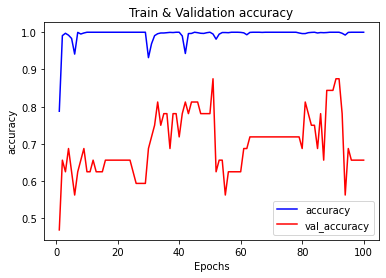

In [ ]:
plot(history, "accuracy", "accuracy", "Train & Validation accuracy")


['loss', 'accuracy', 'val_loss', 'val_accuracy']


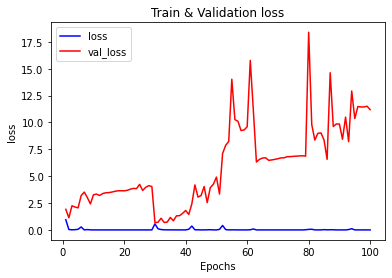

In [ ]:
plot(history, "loss", "loss", "Train & Validation loss")
